## Autoencoders

Examples and useful reading:
- https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
- https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
- https://github.com/Fraser-Greenlee/T5-VAE

Datasets:
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://lionbridge.ai/datasets/20-best-image-datasets-for-computer-vision/

The following autoencoder was trained on the Visual Genome dataset of 40k+ images of various sizes.
Using PyTorch transformers we can bootstrap the dataset by flipping the images, adding random noise, etc.

This workbook is basically a scratch pad for iterating on a simple auto encoder for use in upcoming projects within this repo. In theory it'll be used as a pre-processor for things like image labeling and in reinforcement learning for games. The idea is that by compressing the image via the encoder network in a way that preserves important structure we can reduce the size and/or training time of downstream networks.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([500, 500, 3])


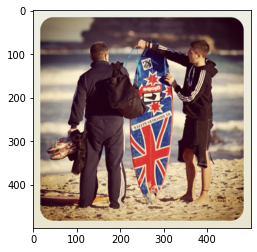

In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import math

from data.visual_genome import VisualGenomeDataset
from torch.utils.data import DataLoader

from encoders import conv, vae, cnn

# filter the annoying warnings
import warnings
warnings.filterwarnings("ignore")

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# data = datasets.ImageFolder('./data/images/', transform=transform)
data = VisualGenomeDataset('./data/images/1')
dataloader = DataLoader(data, batch_size=1, shuffle=True, num_workers=1)

img = next(iter(dataloader))[0] # returns a list, so we fetch the tensor holding the batch of images
print(img.shape) # sanity check to ensure we indexed correctly
plt.imshow(  img  )

In [2]:
def train(model, train_loader, checkpoint_path='./autoencoder-continued.cpt', num_epochs=5, learning_rate=1e-3, restore=False):
    criterion = nn.MSELoss().cuda() # mean square error loss
    device = torch.device('cuda:0')
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    loss = None
    if restore:
        model.load(checkpoint_path, optimizer)

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch: ', epoch)
        i = 0
        for img in train_loader:
            img = img.cuda()
            optimizer.zero_grad()
            recon = model(img)
            loss = criterion(recon, img)
            del recon, img
            loss.backward()
            i += 1
            if i % 10 == 0:
                try:
                    print('Epoch:{}, Batch:{}, loss:{:.4f}'.format(epoch, i, loss.item()))
                except UnboundLocalError:
                    pass
            del loss
            optimizer.step()
            torch.cuda.empty_cache()
    return model


In [32]:
# model = cnn.AutoEncoder(3, latent_channels=3)

# checkpoint = torch.load('./cnn-3.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.train()
# model.to(torch.device('cuda:0'))
crops = [
#     (320, 360),
#     (400,280),
#     (320,320),
    (440,360),
    (280,320),
    (400,400), 
    (480,200)
]
for crop in crops:
#     print('running with crop:', crop)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(500),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(crop),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
    ])

    data = VisualGenomeDataset('./data/images/1', transform=transform)
    dataloader = DataLoader(data, batch_size=200, shuffle=True, num_workers=3)
#     print('img: ', data[0].shape)
#     print('rec:', model(data[0].unsqueeze(0)).shape)
#     print('')
    model = train(model, dataloader, num_epochs=1, learning_rate=1e-4)

    
# z = data[0].unsqueeze(0).cuda()
# for layer in model.encoder:
#     z = layer(z)
# print(z.shape)

Epoch:  0
Epoch:0, Batch:10, loss:0.0060
Epoch:0, Batch:20, loss:0.0060
Epoch:0, Batch:30, loss:0.0057
Epoch:0, Batch:40, loss:0.0060
Epoch:0, Batch:50, loss:0.0061
Epoch:0, Batch:60, loss:0.0060
Epoch:0, Batch:70, loss:0.0059
Epoch:0, Batch:80, loss:0.0064
Epoch:0, Batch:90, loss:0.0062
Epoch:0, Batch:100, loss:0.0058
Epoch:0, Batch:110, loss:0.0060
Epoch:0, Batch:120, loss:0.0059
Epoch:0, Batch:130, loss:0.0057
Epoch:0, Batch:140, loss:0.0059
Epoch:0, Batch:150, loss:0.0059
Epoch:0, Batch:160, loss:0.0061
Epoch:0, Batch:170, loss:0.0063
Epoch:0, Batch:180, loss:0.0058
Epoch:0, Batch:190, loss:0.0057
Epoch:0, Batch:200, loss:0.0059
Epoch:0, Batch:210, loss:0.0059
Epoch:  0
Epoch:0, Batch:10, loss:0.0067
Epoch:0, Batch:20, loss:0.0065
Epoch:0, Batch:30, loss:0.0065
Epoch:0, Batch:40, loss:0.0068
Epoch:0, Batch:50, loss:0.0063
Epoch:0, Batch:60, loss:0.0068
Epoch:0, Batch:70, loss:0.0066
Epoch:0, Batch:80, loss:0.0066
Epoch:0, Batch:90, loss:0.0061
Epoch:0, Batch:100, loss:0.0068
Epoch:

In [29]:
model.save('./cnn-3.pt')

In [20]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

model.eval()
model.to(torch.device('cpu'))

# checkpoint = torch.load('./cnn-3.pt')
# m = cnn.AutoEncoder(3, latent_channels=3)
# m.load_state_dict(checkpoint['model_state_dict'])
# m.eval()
# data = VisualGenomeDataset('./data/images/1')
data = VisualGenomeDataset('./data/images/1', transform=transform)

In [30]:
i = data[2]

z = i.unsqueeze(0)
for layer in model.encoder:
    z = layer(z)

print(z.shape)

recon = model(i.permute(0,1,2).unsqueeze(0).float())
recon = recon.detach()[0]
print('orig shape', i.shape)
print('recon shape', recon.shape)

torch.Size([1, 3, 60, 42])
orig shape torch.Size([3, 500, 354])
recon shape torch.Size([3, 496, 352])


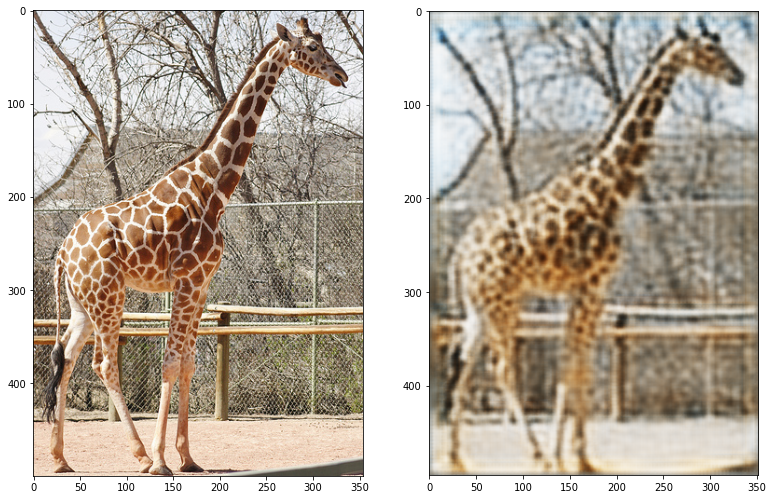

In [31]:
f, axarr = plt.subplots(1,2, figsize=(13,13))
axarr[0].imshow(i.permute(1,2,0))
axarr[1].imshow(recon.permute(1,2,0))

In [35]:
encoder_layers = [l.__repr__() for l in model.encoder.children()]
decoder_layers = [l.__repr__() for l in model.decoder.children()]

In [39]:
state = {
            'encoder': encoder_layers,
            'decoder': decoder_layers,
            'model_state_dict': model.state_dict(),
            'epoch': 10,
        }
torch.save(state, './dist/cnn.pt')

In [40]:
check = torch.load('./dist/cnn.pt')
check['encoder']

['Sequential(\n  (0): Conv2d(3, 3, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))\n  (1): LeakyReLU(negative_slope=0.01)\n  (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n)',
 'Sequential(\n  (0): Conv2d(3, 3, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))\n  (1): LeakyReLU(negative_slope=0.01)\n  (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n)',
 'Sequential(\n  (0): Conv2d(3, 3, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))\n  (1): LeakyReLU(negative_slope=0.01)\n  (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n)']